In [1]:
import time
import numpy as np

import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import random
import timeit
import copy
import pandas as pd
import warnings
import scipy.integrate as integrate
warnings.filterwarnings('ignore')
import sys,os
sys.path.append(os.path.abspath("../"))
from LBL_funcs_waterRTM import *
import re
from sklearn.metrics import r2_score
from scipy.special import erf

In [2]:
import scipy.integrate as integrate

dnu = 5 # spectral resolutio
nu = np.arange(1, 33333+dnu,dnu)  # cm-1
# wavelength [um]
# a = 1/nu*1e4  # cm-1 -> um
# lam = a[::-1]  # um
# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
#wavelengths = np.arange(1e-9, 10e-6, 1e-9) * 1e6

T = np.arange(800,5800+500,500)  # K
T = np.append(300,T)

F_dw_os = np.zeros([T.shape[0], nu.shape[0]])
Intens = np.zeros(T.shape[0])

for tt in range(T.shape[0]):
    # wave number
    F_dw_os[tt] = Planck(nu,T[tt])*math.pi
    #F_dw[tt] = Planck_lam(wavelengths,T[tt])#*math.pi
    #Intens[tt] = integrate.trapz(F_dw[tt], wavelengths)
    Intens[tt] = integrate.trapz(F_dw_os[tt], nu)
print(T)

[ 300  800 1300 1800 2300 2800 3300 3800 4300 4800 5300 5800]


## extract file

In [3]:
def calculateF(res,nu):
    F_total = 0
    items1 = ['F_n_abs', 'F_n_abs_rights','F_n_abs_leftn','F_n_abs_fronte','F_n_abs_backw']
    for item in items1:
        temp = res.item().get(item)
        F_i = integrate.trapz(temp, nu, axis=1)
        F_total += np.sum(F_i)
    F_1stLayer = res.item().get("F_n_abs")[-2]
    F50 = res.item().get("F_n_abs")[-52:-2]
    F_body = res.item().get("F_n_abs")[1:-2]
    F_edge = res.item().get('F_n_abs_rights') + res.item().get('F_n_abs_leftn') \
             + res.item().get('F_n_abs_fronte') + res.item().get('F_n_abs_backw')
    F_bottom= res.item().get('F_n_abs')[0]
    F_dw = res.item().get('F_n_dw')
    F_uw = res.item().get('F_n_uw')
    return F_total, F_bottom, F_1stLayer, F_body, F_edge, F_dw, F_uw, F50


path = "./Tdepth/"
Fls = os.listdir(path)

# all files.npy in the folder
Fls = [s for s in Fls if s.endswith('_200layer_1000bundle_randtheta.npy')]
len(Fls)

12

In [4]:
import re
layers = []
Temp = []
for string in Fls:
    match = re.search(r'([\d.]+)_results', string)
    if match:
        Temp.append(int(match.group(1)))
df1 = pd.DataFrame({"Temp":Temp})

In [5]:
# 2. extract all kinds of energy and save it as pandas
# allocate a empty dataframe
df2 = pd.DataFrame(columns=["F_total","F_bottom","F_1stLayer","F_body","F_edge","F_dw","F_uw","F50"])
for i in range(len(Fls)):
    res = np.load(path+Fls[i], allow_pickle=True)
    columns = ["F_total", "F_bottom", "F_1stLayer", "F_body", "F_edge", "F_dw", "F_uw", "F50"]
    values = calculateF(res, nu)
    df2.loc[i, columns] = values
df = pd.concat([df1, df2], axis=1)
del df1, df2

df = df.sort_values(by='Temp')

In [6]:
df.drop('F_uw', axis=1, inplace=True)
aaa = integrate.trapz(F_dw_os,nu,axis=1)
df['fos']=aaa
df['incident'] = df['F_dw'].apply(lambda x:integrate.trapz(x[-1],nu)).values
df['F_bottom'] = df['F_bottom'].apply(lambda x:integrate.trapz(x,nu)).values
df.drop('F_dw', axis=1, inplace=True)
df

,Temp,F_total,F_bottom,F_1stLayer,F_body,F_edge,F50,fos,incident
8,300,431.824636,6.400415e-21,"[3.7359783493901053e-06, 0.0001418421351400340...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.592996e+02,4.318246e+02
3,800,21918.73464,2.692556e-04,"[9.977559569305276e-06, 0.00038109862122359217...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.322582e+04,2.191873e+04
1,1300,152694.692388,7.141059e+00,"[1.6219144240228097e-05, 0.0006203584144660142...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.619513e+05,1.526948e+05
7,1800,560876.465454,9.062037e+02,"[2.246072948631808e-05, 0.0008596187589093682,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5.952524e+05,5.608912e+05
6,2300,1493744.570199,1.616486e+04,"[2.8702314932467255e-05, 0.0010988792950752265...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.586799e+06,1.494044e+06
0,2800,3276816.690385,1.121659e+05,"[3.494390047150848e-05, 0.00133813992025514, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.485207e+06,3.279059e+06
5,3300,6311405.676136,4.570822e+05,"[4.118548606120037e-05, 0.001577400593988227, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6.722690e+06,6.320944e+06
11,3800,11067638.100767,1.335527e+06,"[4.7427071681560534e-05, 0.0018166612971087133...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.180804e+07,1.109610e+07
2,4300,18067254.053811,3.120691e+06,"[5.366865732188941e-05, 0.0020559220193652797,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.930748e+07,1.813425e+07
9,4800,27853983.813814,6.224573e+06,"[5.9910242975961936e-05, 0.0022951827547775644...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.981158e+07,2.798746e+07


In [7]:
dff = pd.DataFrame()
dff['a_bottom'] = df['F_bottom']/df['fos']
dff['a_edge'] = df['F_edge']*5/df['fos']
dff['a_body'] = df['F_body']*5/df['fos']
dff['a_1stLayer'] = df['F_1stLayer']*5/df['fos']
dff['a_rf'] = 1-(df['incident']/df['fos'])
dff.set_index(df['Temp'].values,inplace=True)

In [8]:
dff['a_edge'] = dff['a_edge'].apply(lambda x:np.sum(x)).values

dff['a_body'] = dff['a_body'].apply(lambda x:np.sum(x)).values

dff['a_bottom'] = dff['a_bottom']#.apply(lambda x:np.sum(x)).values
#dff['a_in'] = df['incident']/df['fos']

dff['a_1stLayer'] = dff['a_1stLayer'].apply(lambda x:np.sum(x)).values

In [9]:
dfs = pd.DataFrame()
#dfs['a_body'] = df['F_body']
dfs['F_1stLayer'] = df['F_1stLayer'].apply(lambda x:integrate.trapz(x,nu)).values
dfs['F50'] = df['F50'].apply(lambda x:integrate.trapz(x,nu)).values
dfs['F50'] = dfs['F50'].apply(lambda x:np.sum(x)).values
dfs.set_index(df['Temp'].values,inplace=True)

In [10]:
dfs # dfs['F50'].values + dfs['F_1stLayer'].values

,F_1stLayer,F50
300,4.318246e+02,5.280725e-09
800,2.191302e+04,5.705135e+00
1300,1.503465e+05,2.296928e+03
1800,5.157884e+05,4.167777e+04
2300,1.213357e+06,2.370848e+05
2800,2.269098e+06,7.627923e+05
3300,3.661229e+06,1.775091e+06
3800,5.347893e+06,3.377204e+06
4300,7.283922e+06,5.624538e+06
4800,9.428270e+06,8.543737e+06


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap
colors = ["#09306B", "#2171B5", "#6CAED6", "#B8CBDD","C2"]  # just an example, replace with your desired colors
n_bins = [20, 40, 60, 80,100]  # Discretizes the interpolation into bins
cmap_name = "custom_div_cmap"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

In [12]:
df.set_index(df['Temp'].values,inplace=True)
dfs['F_1stLayer'] = df['F_1stLayer'].apply(lambda x:integrate.trapz(x,nu)).values
dfs['F50'] = df['F50'].apply(lambda x:integrate.trapz(x,nu,axis=1)).values
dfs['F50'] = dfs['F50'].apply(lambda x:np.sum(x)).values
temp = dfs['F_1stLayer']+dfs['F50']
rf50s=temp/df['fos']

In [13]:
# New column names
new_columns = ['Bottom', 'Edges', 'Body','Surface', r'Reflection rate']

# Replace dff's columns with the new ones
dff.columns = new_columns

In [14]:
dff['Bottom'] = dff['Bottom']+dff['Edges']
dff.drop('Edges',axis=1, inplace=True)
dff

,Bottom,Body,Surface,Reflection rate
300,4.476881e-18,1.149734e-11,0.940181,0.059819
800,1.020726e-07,2.459437e-04,0.943477,0.056277
1300,6.842067e-05,1.443069e-02,0.928344,0.057156
1800,1.879398e-03,7.386680e-02,0.866504,0.057725
2300,1.185665e-02,1.648437e-01,0.764657,0.058454
2800,3.657790e-02,2.525639e-01,0.651065,0.059149
3300,7.634845e-02,3.178654e-01,0.544608,0.059760
3800,1.261266e-01,3.582681e-01,0.452903,0.060293
4300,1.794657e-01,3.790415e-01,0.377259,0.060766
4800,2.311831e-01,3.868933e-01,0.316262,0.061188


In [15]:
new_columns = ['Bottom+Edges', 'Body','Surface', r'Reflection rate']

#Replace dff's columns with the new ones
dff.columns = new_columns

In [16]:
f50s = rf50s

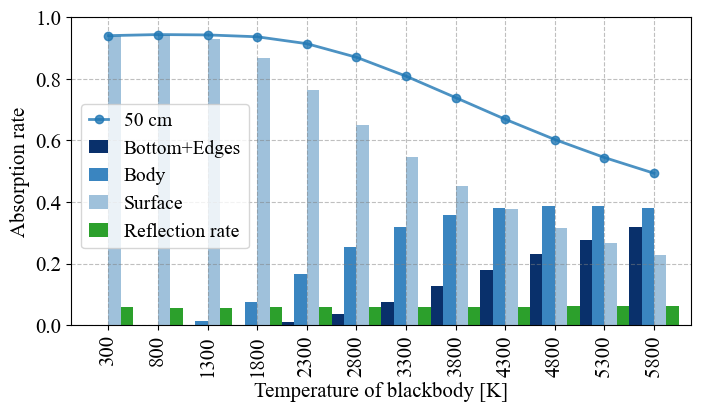

In [17]:
from matplotlib.font_manager import FontProperties

font=15
fontfml='Times New Roman'

plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml

colors_for_plot = cm(np.linspace(0, 1, len(dff.columns)))

fig, ax = plt.subplots(figsize=(8, 4))

ax = dff.plot(kind='bar', stacked=False, color=colors_for_plot, width=1,
              xlabel=r"Temperature of blackbody [K]", ylabel="Absorption rate", ax=ax)
xticks = ax.get_xticks()

ax.plot(xticks, rf50s.values, 'o-',color='C0',
        linewidth=2,alpha=0.8,label=r'50 cm')

ax.set_ylim(0,1)
font = FontProperties(family=fontfml, size=14)
legend = ax.legend(prop=font,loc='upper left',bbox_to_anchor=(0., 0.75), ncol=1, handlelength=1)

ax.xaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)
ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=.5)


#ax.legend(loc='upper right')

figpath='../figure/'
fig.savefig(figpath +'black_temp.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

In [21]:
rf50s

300     0.934020
800     0.937504
1300    0.936083
1800    0.927831
2300    0.900806
2800    0.851492
3300    0.785757
3800    0.712507
4300    0.639271
4800    0.570875
5300    0.509703
5800    0.456437
dtype: float64